# Imports

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import warnings


# Configs

In [128]:
LABELED_PATH = "../data/results/labels.parquet"
PREDICTED_PATH = "../data/results/xgb_prediction_labeled.parquet"
TEST_START_DATE = '2023-04-01'
IMPORTANT_LOCATIONS = 50
warnings.filterwarnings('ignore')

In [129]:
predictions_dict = {
    'baseline_last_day':None,
    'baseline_last_week':None,
    'arima':None,
    'model_regression':None,
    'model_xgboost':None,
}

# Load Data

## Load labeled data

In [132]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [133]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0
...,...,...,...
7855,265,2023-04-26,78.0
7856,265,2023-04-27,44.0
7857,265,2023-04-28,55.0
7858,265,2023-04-29,45.0


In [136]:
def join_actual_predict(actual_df, predicted_df):
    actual_predicted_df = actual_df.copy()
    actual_predicted_df['Predicted_demand'] = predicted_df['Predicted_demand']
    actual_predicted_df = actual_predicted_df.dropna()
    return actual_predicted_df

## Load Predicted Date

In [139]:
predictions_dict['model_xgboost'] = pd.read_parquet(PREDICTED_PATH)
predictions_dict['model_xgboost'].tail()

,Location,Date,Predicted_demand
7855,265,2023-04-26,53.553493
7856,265,2023-04-27,76.140839
7857,265,2023-04-28,56.882065
7858,265,2023-04-29,55.795795
7859,265,2023-04-30,55.706608


In [140]:
predictions_dict['model_xgboost'] = join_actual_predict(test_df, predictions_dict['model_xgboost'])
predictions_dict['model_xgboost'].head()

,Location,Date,Demand,Predicted_demand
0,1,2023-04-01,13.0,9.159037
1,1,2023-04-02,17.0,5.113592
2,1,2023-04-03,9.0,11.624486
3,1,2023-04-04,12.0,9.921972
4,1,2023-04-05,18.0,7.794608


### BaseLine Models

In [144]:
def baseline_predict(dataset, shift_val):
    predicted_demand = dataset.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    return predicted_data

In [145]:
predictions_dict['baseline_last_day'] = join_actual_predict(labeled_df,baseline_predict(labeled_df, 1))
predictions_dict['baseline_last_week'] = join_actual_predict(labeled_df,baseline_predict(labeled_df, 7))

## Mape Calculation

In [141]:
def calculate_mape(actual_predicted_df:pd.DataFrame):
    
    actual_predicted_df['Demand'] = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
    actual_predicted_df['error'] = (
        np.abs(actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand'])
        /actual_predicted_df['Demand']
        )*100

    return actual_predicted_df


In [143]:
predictions_dict['model_xgboost'] = calculate_mape(predictions_dict['model_xgboost'])
predictions_dict['model_xgboost']

,Location,Date,Demand,Predicted_demand,error
0,1,2023-04-01,13.0,9.159037,29.545872
1,1,2023-04-02,17.0,5.113592,69.920049
2,1,2023-04-03,9.0,11.624486,29.160955
3,1,2023-04-04,12.0,9.921972,17.316898
4,1,2023-04-05,18.0,7.794608,56.696624
...,...,...,...,...,...
7855,265,2023-04-26,78.0,53.553493,31.341675
7856,265,2023-04-27,44.0,76.140839,73.047361
7857,265,2023-04-28,55.0,56.882065,3.421936
7858,265,2023-04-29,45.0,55.795795,23.990657


In [147]:
predictions_dict['baseline_last_day'] = calculate_mape(predictions_dict['baseline_last_day'])
predictions_dict['baseline_last_week'] = calculate_mape(predictions_dict['baseline_last_week'])

In [148]:
predictions_dict['baseline_last_day'].head()

,Location,Date,Demand,Predicted_demand,error
1,1,2023-01-02,31.0,40.0,29.032258
2,1,2023-01-03,27.0,31.0,14.814815
3,1,2023-01-04,7.0,27.0,285.714286
4,1,2023-01-05,15.0,7.0,53.333333
5,1,2023-01-06,11.0,15.0,36.363636


### Plot Mape for Models Predicted

In [149]:
def plot_mape(errors: pd.DataFrame):
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,10))
    for label,error_df in errors.items():
        if (error_df is not None):                        
            sorted_index = error_df.groupby('Location')['Demand'].aggregate(['sum']).sort_values('sum', ascending=False)
            sorted_index = sorted_index.reset_index()
    
            error_location_df=error_df.groupby('Location')['error'].mean()
            error_location_df = error_location_df.reindex(sorted_index['Location'])
            error_location_df = error_location_df.reset_index()
            error_location_df['Location'] = error_location_df['Location'].astype(str)

            # devide in to three sections(based on demands)
            error_location_df1 = error_location_df.iloc[:50]
            error_location_df2 = error_location_df.iloc[50:150]
            error_location_df3 = error_location_df.iloc[150:]
            
            error_location_df1.plot(y='error',kind='line',ax = axes[0], label=label )
            axes[0].set_xticklabels(error_location_df1['Location'])
            error_location_df2.plot(y='error',kind='line',ax = axes[1], label=label)
            axes[1].set_xticklabels(error_location_df2['Location'])
            error_location_df3.plot(y='error',kind='line',ax = axes[2], label=label)
            axes[2].set_xticklabels(error_location_df3['Location'])

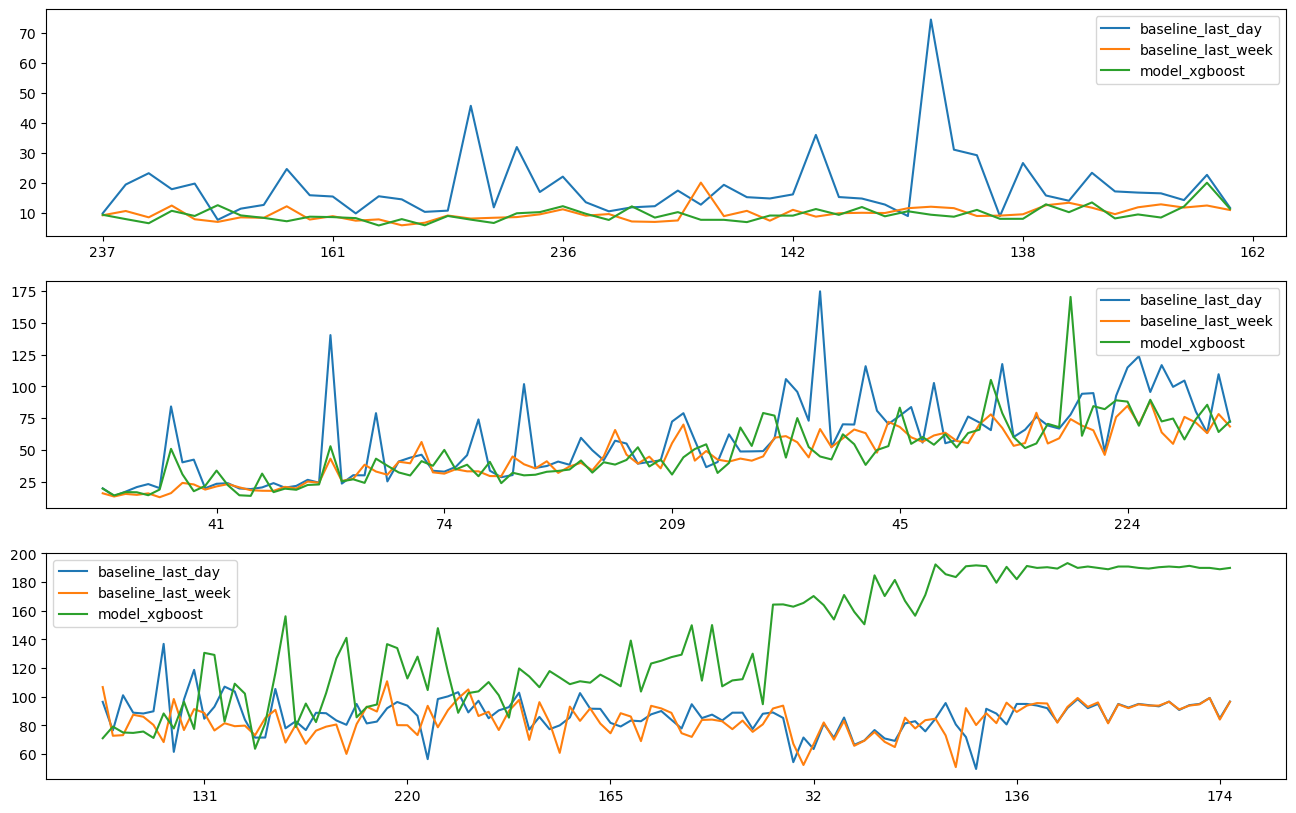

In [150]:
plot_mape(predictions_dict)